#Image Inpainting

---------------------------------------------

## 1. Introduction



### **1.1. Loading in the image**

Loading int tge `.txt` file of the image.

- First begin with importing `numpy` and `matplotlib.pyplot` packages.
- Loading in the text file and store in the variable X.
- Obtaining the shape of this matrix
- Calculating the rank of the matrix using a pre-defined function
- Plotting the monochrome image

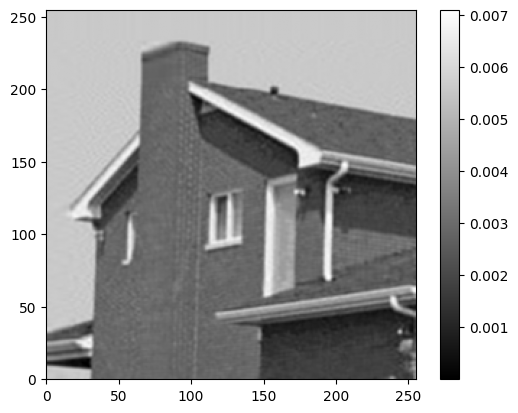

In [2]:
# Import the required packages
import numpy as np
import matplotlib.pyplot as plt
import time

# Load the txt file and assign the data to the matrix X
X = np.loadtxt('Test_Image.txt')
#print(X)
# Obtain the size of the input matrix . The size will be given by N whose first element is the number of rows and the second is the number of columns . The matrix in question is square so both are equal anyway .
N = np.shape(X)
#print(N)

# Obtain the rank of the matrix
rank_X = np.linalg.matrix_rank(X)
#print(rank_X)

# Plot the image encoded by the matrix X in grayscale . The commands are:
# extent : This gives the range at which the image should be displayed . So for animage size MxN , the extent should be from 0 to M -1 in the horixntal range and 0to N -1 in the vertical range .
# aspect : Gives the aspect ratio which is set to 1 for a square image
# Also , display a colour bar to indicate the values that each color corresponds to.
plt.imshow(X, cmap ='gray',extent =[0, N[0]-1,0 , N [1] -1] , aspect =1)
plt.colorbar()
plt.show()

Observe that the above image is a that of a black and white house. Now, retaining only a percentage of the pixels to form our incomplete image:

### **1.2. Undersampling the image of the house and displaying the image with the points that were retained**

- Setting the under-sampling ratio
- Constructing the Masking Operator used to under-sample
- Obtaining the incomplete image D and displaying it

**Note:** The masking operator M is essentially a brodcasted way of developing the projection function. We use random numbers from normal distribution and under-sampling ratio to generaate a matrix of 0s and 1s. The indices of the entries equal to 1 essentially belong to the set $\Omega$.

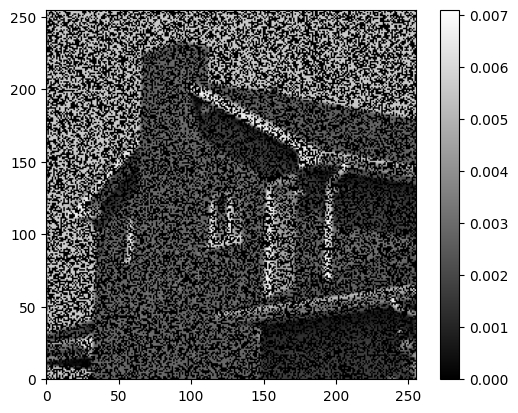

In [3]:
# Import the required package
import random

# Define p in [0 ,1] as the under - sampling ratio and let t=1 -p. This means that 100p% of the data is retained and 100t% is set to 0.
p = 0.50
t = 1 - p

# In order to have consistency when choosing the random points ( mainly for reproducibility ), establish a random seed before choosing the set of random points . Note that every time a set of random numbers are to be generated , the seed has to be called again before the random number generator is called .
np.random.seed (42)

# Now define the masking operator M to be of the same shape as the image matrix X and fill all the entries with random numbers that are normally distributed points between 0 and 1. Set all the elements of M that are less than t to 0 and set the others to 1.
M = np.random.rand( N[0], N[1])
#print(M)
M[M<= t] = 0
M[M>0] = 1
#print(M)


# Finally , the matrix D will be the mask M multiplied element - wise by the image X.
D = M * X
#print(D)

# Show the under - sampled image D.
plt.imshow (D, cmap ='gray', extent =[0, N[0]-1 ,0 , N[1]-1] , aspect =1)
plt.colorbar()
plt.show()


50% of the pixels from the orginal image X are removed and the remaining 50% are retained. The under-sampled image (array of pixels) is now stored in D.

### **1.3. Approximating M and p of image X**

- Generating the masking operator based on the size of the input
- Setting entries in M to 0 if the corresponding entry in X is equal to 0
- Finding the under-sampling ratio

**Note:** For our case, we will assume that the zeros in the altered image D is due to the masking operator M. Our original image has no entries equal to 0 as we can see from the code below.


In [4]:
# Let M be a matrix of ones of the same size as the input
M = np.ones(np.shape(X))

# Let the terms of M be equal to 0 in the locations where X=0
M[X==0]=0

# The under - sampling ratio is the number of non - zero terms in M ( which is in fact the sum of all the terms of M) divided by the total size of the input image X
p = np.sum(M)/(np.size(X))


Since we find the under-sampling ratio p based on the input image (unaltered image), 100% of the pixels are retained.

## 2. The Alternating Steepest Descent (ASD) Algorithm



### **2.1. Writing the code to impement the ASD algorithm:**

- Defining a function `asd_algortihm` with relevant inputs
- Starting by computing the size $N$ of the input image
- Initialising the matrices $A\in \mathbb{R}^{N \times r}$ and $B\in \mathbb{R}^{r\times N}$ using the command `random.ran`
- Nomalizing th matrices in order to have the Frobenius norm equal to 1, i.e. $||.||_F = 1$
- Extracting the approximation to the masking operator $M$ from the undersampled image $D$ using the idea from the previous section
- Defining an empty list for the residuals
- Setting up the `for` loop and iterate till the maximum number of iterations is acheieved or the stopping criterion is met (for this we use a `if` condition at the end of the loop for it and use the `break` command to exit the iteration
- Computing the corresponding gradients and stepsizes and update the parameters
- Computing the relative residuals for the parameteres and appending it to the list
- Calculating the output $\hat{X}$
- Returning $\hat{X}$ and residuals

In [5]:
def asd_algorithm(D, r, rho, max_iters):
    """
    This function calculates predictions A and B as well as the residuals by running the steepest descent algorithm

    Arguments:
    D - under-sampled image, a numpy array of size (N*N)
    r - rank of the matrix X from which D was under-sampled
    rho - tolerance used to set the stopping criterion
    max_iters - maximum number of allowable iterations

    Returns:
    X_cap - an array the predicted values of the pixels (approximates X)
    residuals - a list of the relaive residulas captured at every iteration

    """

    #Find the size N of the input image
    D_shape = np.shape(D)
    N = D_shape[0]

    #Initialise matrices
    A = np.random.rand(N, r)
    B = np.random.rand(r, N)

    # Normalize matrices to have Frobenius norm equal to 1
    norm_A = np.linalg.norm(A, 'fro')
    norm_B = np.linalg.norm(B, 'fro')

    A /= norm_A
    B /= norm_B

    #Extracting approximations to the masking operator M from the under-sampled image D
    M = np.ones(D_shape)
    M[D == 0] = 0

    #Initialize residual list to store relative residuals
    residuals = []

    #for k=0,1,.... until stopping criterion is satisfied
    for k in range(max_iters):


        #Compute gradient with B constant
        gradient_A = - np.dot(M*D - M*np.dot(A,B), B.T)

        #Compute steepest descent
        frobA = np.linalg.norm(gradient_A, 'fro') #Computing the frobenius norm for gradient A
        steepest_descent_A =  frobA ** 2 / np.linalg.norm(M * np.dot(gradient_A , B), 'fro') ** 2

        #Update the parameter A
        A -= steepest_descent_A * gradient_A

        #Compute gradient with A constant
        gradient_B = - np.dot(A.T, (M*D - M*np.dot(A,B)))

        #Compute steepest descent
        frobB = np.linalg.norm(gradient_B, 'fro') #Computing the Frobenius norm for gradient B
        steepest_descent_B =  frobB ** 2 / np.linalg.norm(M * np.dot(A, gradient_B), 'fro') ** 2

        #Update the parameter B
        B -= steepest_descent_B * gradient_B

        # Compute the relative residual
        relative_residual = np.linalg.norm(D - M *np.dot(A,B), 'fro') / np.linalg.norm(M * D, 'fro')

        # Store the relative residual in the residuals list
        residuals.append(relative_residual)


        #Setting up the stopping criteria
        stop_cond = np.linalg.norm(M*(np.dot(A,B)-D), 'fro') / np.linalg.norm(M*D, 'fro')
        if stop_cond < rho:
            break

    #Computing X_cap
    X_cap = np.dot(A,B)

    #Return output X=AB and residuals
    return X_cap, residuals

### **2.2 Testing**

**a) Test 1 - Testing the algorithm using on a small Simple Matrix**

- Considering a $3\times 3$ matrix X with rank 2
- Removing 25% of the data and storing it in D using masking approximation
- Setting $\rho=0.001$ and maximum number of iterations to 100
- Displaying the results of the approximations

In [6]:
#Testing using a simple matrix

X = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
N = np.shape(X)
p = 0.75
t = 1- p
M = np.random.rand( N[0], N[1])
M[M<= t] = 0
M[M>0] = 1
D = M*X


r = np.linalg.matrix_rank(X)
rho = 0.001
max_iters = 100

Xb, residuals = asd_algorithm(D, r, rho, max_iters)

#Display the results
print("Original Matrix X:")
print(X)
print("\nApproximated Matrix Xb:")
print(Xb)


Original Matrix X:
[[1 2 3]
 [4 5 6]
 [7 8 9]]

Approximated Matrix Xb:
[[0.99448662 2.01232097 2.99369081]
 [4.67753618 5.33824231 5.99828363]
 [7.00081719 8.00096793 8.99965669]]


**b) Test 2 - Testing the algorithm using a Simple Matrix**

- Considering a $10\times 10$ matrix $X$ with rank 2
- This is generated by taking two full-rank factors $X_L\in\mathbb{R}^{N \times r}$ and $X_R\in\mathbb{R}^{r \times N}$ and taking $X=X_LX_R$
- Removing 50% of the data and storing it in D using masking approximation
- Setting $\rho=0.0001$ and maximum number of iterations to 100
- Displaying the results of the approximations

In [7]:
#Testing using a simple matrix
Xl = np.random.randint(1,20,(10,2))
Xr = np.random.randint(1,20,(2,10))
X = np.dot(Xl,Xr)
N = np.shape(X)
p = 0.50
t = 1- p
M = np.random.rand( N[0], N[1])
M[M<= t] = 0
M[M>0] = 1
D = M*X

r = np.linalg.matrix_rank(X)
rho = 0.0001
max_iters = 100

Xb, residuals= asd_algorithm(D, r, rho, max_iters)
#Display the results
print("Original Matrix X:")
print(X)
print("\nApproximated Matrix Xb:")
print(Xb)

Original Matrix X:
[[172 146 183  86 185  65  36  66  50 136]
 [114 356 241 128 277 105  80 194  48 176]
 [ 82 212 153  80 173  65  48 114  32 112]
 [ 93 183 147  75 162  60  42  96  33 108]
 [176 164 194  92 198  70  40  76  52 144]
 [298 242 312 146 314 110  60 108  86 232]
 [297 159 273 123 264  90  42  60  81 204]
 [216 344 304 152 328 120  80 176  72 224]
 [142 168 173  84 181  65  40  82  44 128]
 [283 253 307 145 312 110  62 116  83 228]]

Approximated Matrix Xb:
[[159.47019965 146.00439193 180.66286648  85.40561757 183.21347825
   64.38592354  36.27691032  66.36248714  49.26717668 134.27873154]
 [162.02625661 355.9940653  241.0588258  129.42475116 277.26465646
  109.20261491  80.08421468 194.04790059  48.16637428 175.47671166]
 [107.13375772 211.95172381 152.90141964  80.76360937 173.04734631
   67.26444392  48.0740716  114.01595576  32.06156529 111.62054932]
 [109.56641443 182.95082858 147.00997804  75.65232778 162.13959612
   61.66190339  42.12678264  95.98581005  33.09742373

**c) Testing the code on the undersampled image**

- Under-sampling ratio of $p=0.5$
- Recovering the image with rank $r=50$
- Tolerance $\rho=0.05$ and a maximum of 500 allowable iterations
- Display the original image, under-sampled image and recovered image to observe the efficacy of the code.



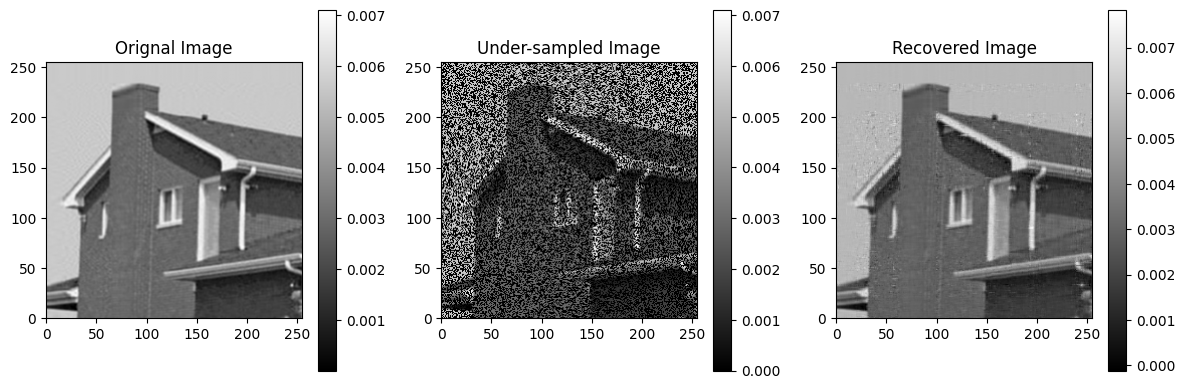

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Load the txt file and assign the data to the matrix X
X = np.loadtxt('Test_Image.txt')
# Obtain the size of the input matrix . The size will be given by N whose first element is the number of rows and the second is the number of columns . The matrix in question is square so both are equal anyway .
N = np.shape(X)
# Obtain the rank of the matrix
r = np.linalg.matrix_rank(X)


# Plot the image encoded by the matrix X in grayscale
#Setting the size of the figure to maintain a constant and well-spaced images thoughout
plt.figure(figsize=(12,4))

#Creating a subplot of 1 row and 3 columns to display the images one under the other

#Sub-plot at 1st position - Original Image
plt.subplot(1,3,1)
plt.title('Orignal Image')
plt.imshow(X, cmap ='gray',extent =[0, N[0]-1,0 , N [1] -1] , aspect =1)
plt.colorbar()


# Under-sampling the image
# Define p in [0 ,1] as the under - sampling ratio and let t=1 -p. This means that 100p% of the data is retained and 100t% is set to 0.
p = 0.50
t = 1 - p
# In order to have consistency when choosing the random points ( mainly for reproducibility ), establish a random seed before choosing the set of random points . Note that every time a set of random numbers are to be generated , the seed has to be called again before the random number generator is called .
np.random.seed (42)
# Now define the masking operator M to be of the same shape as the image matrix X and fill all the entries with random numbers that are normally distributed points between 0 and 1. Set all the elements of M that are less than t to 0 and set the others to 1.
M = np.random.rand( N[0], N[1])
M[M<= t] = 0
M[M>0] = 1

# Finally , the matrix D will be the mask M multiplied element - wise by the image X.
D = M * X #Under-sampled image D

# Showing the under-sampled image D
#Subplot at 2nd position - Undersampled image
plt.subplot(1,3,2)
plt.title('Under-sampled Image')
plt.imshow (D, cmap ='gray', extent =[0, N[0]-1 ,0 , N[1]-1] , aspect =1)
plt.colorbar()


#Setting up the stopping critera according to the question
rho = 0.005
max_iters = 500

#Computing the approximations and residuals of the undersampled image using ASD algorithm
X_cap, residuals = asd_algorithm(D, r, rho, max_iters)

#Subplot at 3rd position - Recovered image
plt.subplot(1,3,3)
plt.title('Recovered Image')
plt.imshow(X_cap, cmap ='gray',extent =[0, N[0]-1,0 , N [1] -1] , aspect =1)
plt.colorbar()

plt.tight_layout()
plt.show()



## 3. Computing the Computational Cost





### **3.1. Estimate the computational cost of one iteration of the loop in Algorithm 1:**
- Setting the `max_iters` parameter to 1
- Computing the computational time using `%time`

In [9]:
%time asd_algorithm(D, r, rho, 1)

CPU times: user 10.5 ms, sys: 2.89 ms, total: 13.3 ms
Wall time: 14 ms


(array([[0.00745805, 0.00761406, 0.00731881, ..., 0.00512827, 0.00515783,
         0.0055875 ],
        [0.00802191, 0.00782742, 0.00799974, ..., 0.00562911, 0.00540682,
         0.0057595 ],
        [0.00763976, 0.00731461, 0.00714819, ..., 0.00510234, 0.00514624,
         0.0053295 ],
        ...,
        [0.00395495, 0.00373653, 0.00370816, ..., 0.00255521, 0.00273718,
         0.00271861],
        [0.00376746, 0.00353329, 0.00379321, ..., 0.00243243, 0.00261286,
         0.00267464],
        [0.00334255, 0.00360568, 0.00348636, ..., 0.00249783, 0.00226857,
         0.00262357]]),
 [0.26609234164834383])

In [10]:
%time asd_algorithm(D, r, rho, 500)

CPU times: user 2.72 s, sys: 1.07 s, total: 3.79 s
Wall time: 2.43 s


(array([[0.00557978, 0.00555304, 0.005526  , ..., 0.00555736, 0.00554261,
         0.00554587],
        [0.00561504, 0.00559104, 0.00559103, ..., 0.00560323, 0.00558722,
         0.00562627],
        [0.0056019 , 0.00559855, 0.00559237, ..., 0.00561125, 0.00562278,
         0.00558921],
        ...,
        [0.00549231, 0.00553231, 0.00551611, ..., 0.00197611, 0.00274305,
         0.00401862],
        [0.0055156 , 0.00544909, 0.00555573, ..., 0.00206115, 0.0029988 ,
         0.00392471],
        [0.00580219, 0.00567868, 0.00564391, ..., 0.00268582, 0.0030704 ,
         0.00349054]]),
 [0.26588544817970494,
  0.26331978133214934,
  0.26030257150674485,
  0.25701344383514885,
  0.25130293711871604,
  0.24424137276883096,
  0.2332479361177191,
  0.22003606214140817,
  0.2059925927171996,
  0.19242211335516865,
  0.18081920921139985,
  0.17079482962449266,
  0.16211652565605214,
  0.15443938906565086,
  0.1476128418666586,
  0.14152553971680137,
  0.13604639472677188,
  0.13111553459719452

### **3.2. Computational time of the function:**

- Importing `timeit`
- Running the function with `max_iters` equal to 500 and letting it break out of the iteration when either of the stopping criteria are met
- Computing the total computational time

In [11]:
import timeit

time_taken = timeit.timeit(lambda: asd_algorithm(D, r, rho, max_iters=500), number=1)
print(f"Computational cost for after meeting stopping criteria to break out of the iteration: {time_taken} seconds")

Computational cost for after meeting stopping criteria to break out of the iteration: 1.7179086109999844 seconds


## 4. Plotting the Relative Residuals graph



### **4.1. Plot a graph displaying the behaviour of the realtive residuals vs the number of iterations.**

- Using `matplotlib.pyplot` to plot the residuals againt number of iterations

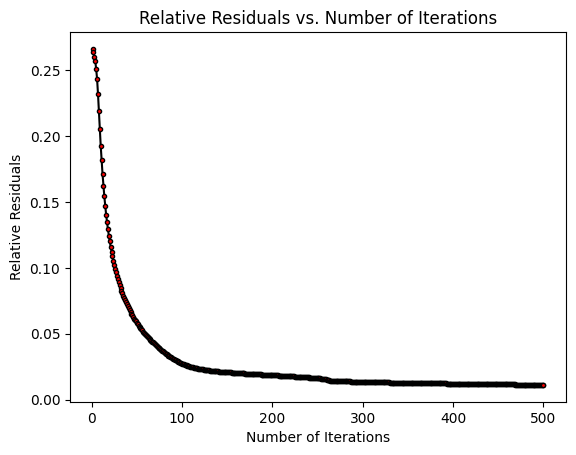

In [12]:
plt.plot(range(1, len(residuals) + 1), residuals, 'k', marker='o', markersize=3, markerfacecolor='red')
plt.title('Relative Residuals vs. Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Relative Residuals')
plt.show()

## 5. Varying parameters for the purpose of comparisons




### **5.1. What happens when the values of the inputted rank $r$ in ASD is larger/smaller that the true rank of $X$ (namely $r=50$)? Explain your observations.**

- Displaying the pictures by considering different values of the rank ranging from 10 to 300 increasing by 20 for each step
- Plotting the corresponding residuals

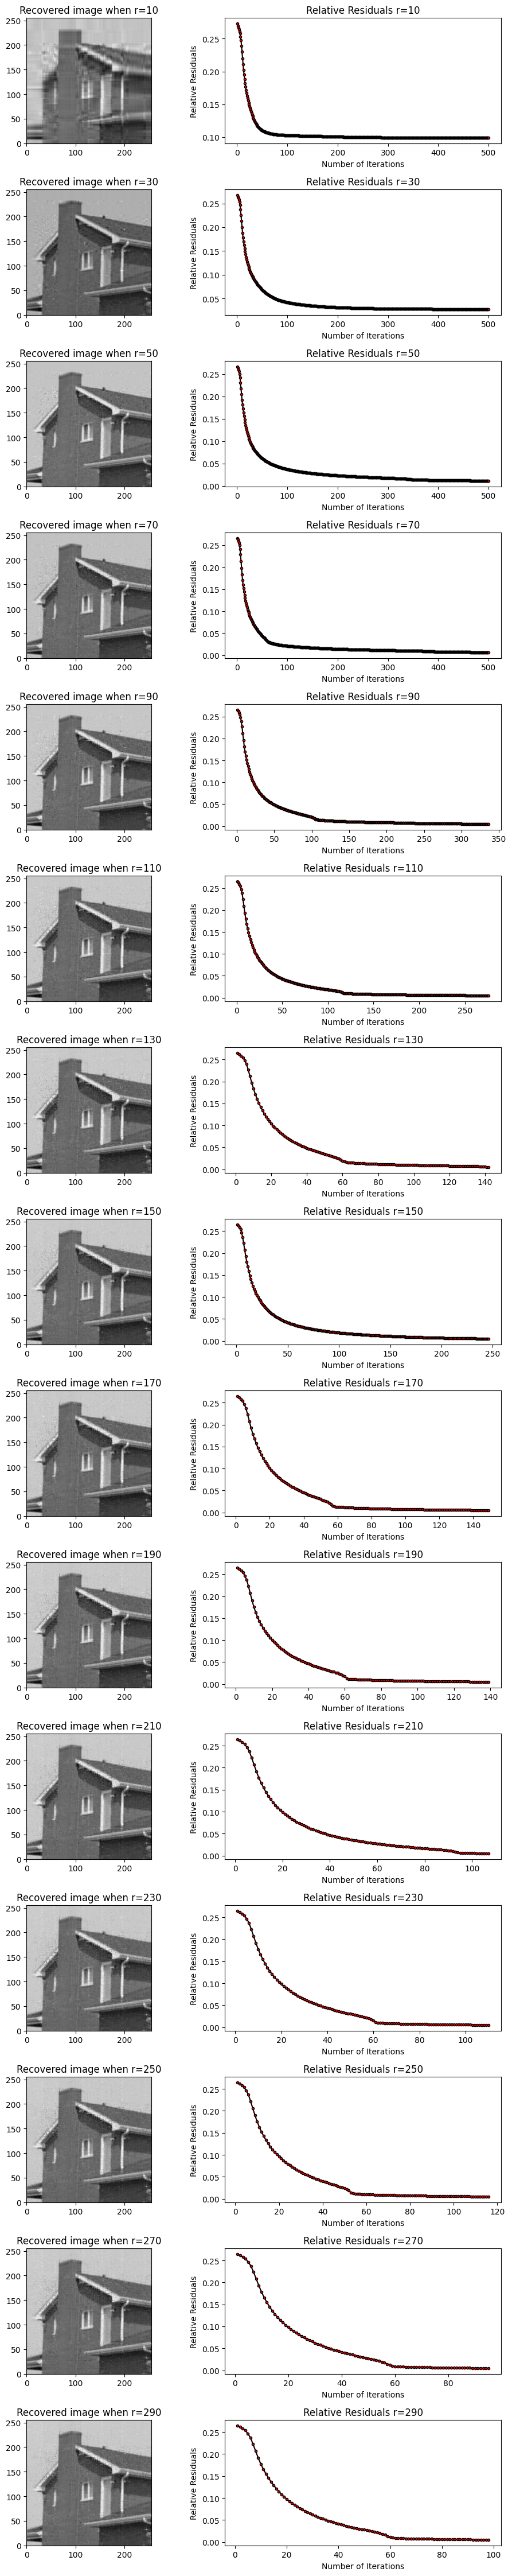

In [13]:
import numpy as np
import matplotlib.pyplot as plt

r_values = np.arange(10, 300, 20)
rho = 0.005
max_iters = 500

fig, axs = plt.subplots(len(r_values), 2, figsize=(10, 3 * len(r_values)))


for i, r in enumerate(r_values):

    # Compute the approximations and residuals of the under-sampled image using ASD algorithm

    X_cap, residuals = asd_algorithm(D, r, rho, max_iters)

   # Plot the under-sampled image
    axs[i, 0].imshow(X_cap, cmap='gray', extent=[0, N[0] - 1, 0, N[1] - 1], aspect=1)
    axs[i, 0].set_title(f'Recovered image when r={r}')

    # Plot the relative residuals
    axs[i, 1].plot(range(1, len(residuals) + 1), residuals, 'k', marker='o', markersize=3, markerfacecolor = 'red')
    axs[i, 1].set_title(f'Relative Residuals r={r}')
    axs[i, 1].set_xlabel('Number of Iterations')
    axs[i, 1].set_ylabel('Relative Residuals')


plt.tight_layout()
plt.show()

**Observations:**

A rank of 50 yields optimal image clarity, with higher ranks capturing intricate details but introducing noise. Lower ranks, like 10, result in significant loss of detail and distorted images. Higher ranks lead to quicker convergence in the algorithm, but also increase computational complexity and memory usage. The choice of rank involves a trade-off between computational efficiency and image quality, emphasizing the need for a balanced selection.



### **5.2. Varying the value of the undersampling ratio for the purpose of comparision**

- Displaying the recovered imaged by considering different values of the $p$ ranging from 0.1 to 0.9 increasing by 0.1 for each step
- Plotting the corresponding residuals

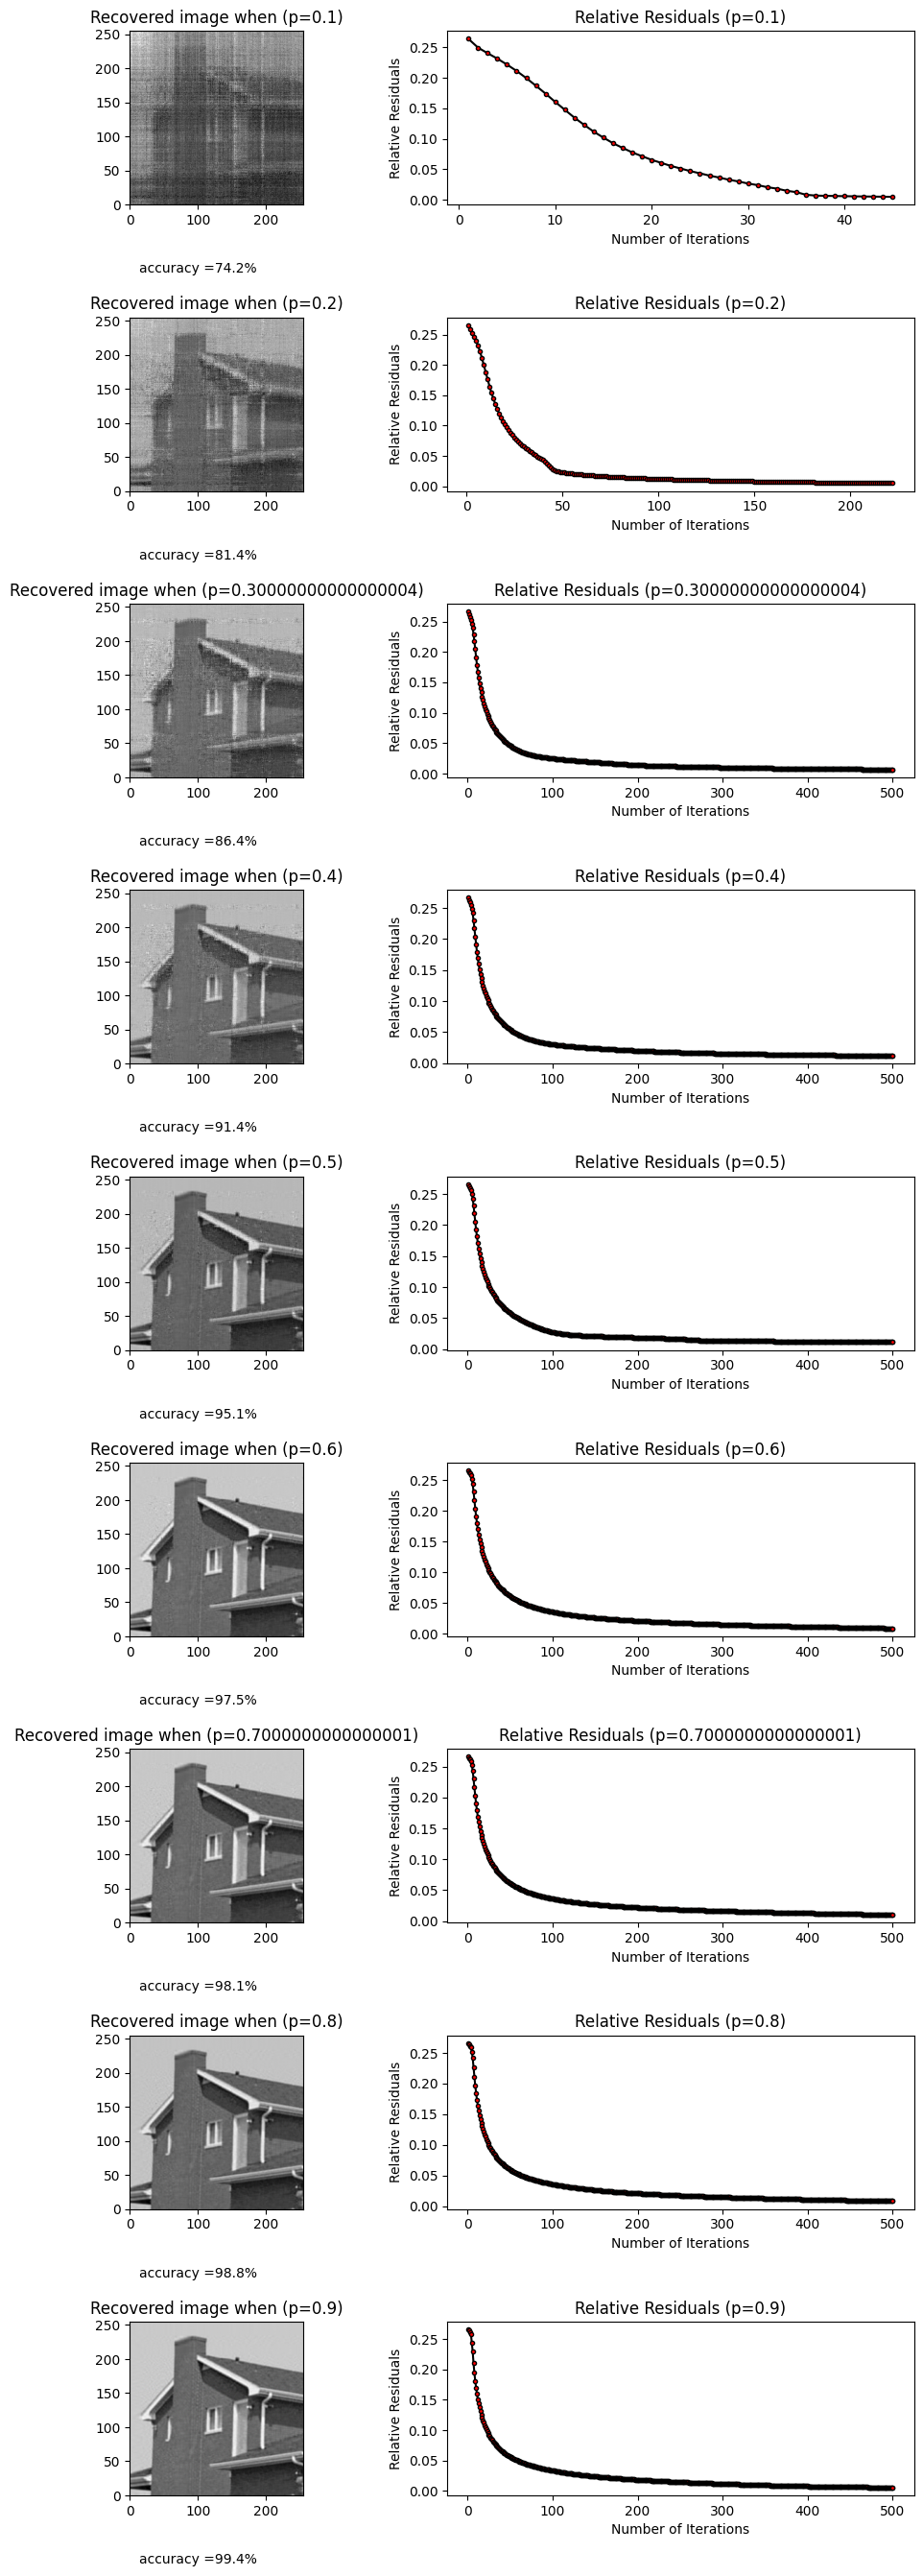

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import random

X = np.loadtxt('Test_Image.txt')
N = np.shape(X)
r = np.linalg.matrix_rank(X)

p_values = np.arange(0.1, 1.0, 0.1)
fig, axs = plt.subplots(len(p_values), 2, figsize=(10, 3 * len(p_values)))


for i, p in enumerate(p_values):
    t = 1 - p

    # Under-sampling the image
    np.random.seed(42)
    M = np.random.rand(N[0], N[1])
    M[M <= t] = 0
    M[M > 0] = 1
    D = M * X  # Under-sampled image D

    # Compute rank of the original matrix X
    r = np.linalg.matrix_rank(X)

    # Compute the approximations and residuals of the under-sampled image using ASD algorithm
    X_cap, residuals = asd_algorithm(D, r, rho, max_iters)

    #Accuracy
    accuracy = np.round(100 - np.linalg.norm(X_cap - X) / np.linalg.norm(X) * 100,1)

    # Plot the under-sampled image
    axs[i, 0].imshow(X_cap, cmap='gray', extent=[0, N[0] - 1, 0, N[1] - 1], aspect=1)
    axs[i, 0].set_title(f'Recovered image when (p={p})')
    axs[i, 0].text(100, -100, f"accuracy ={accuracy}%", ha='center')

    # Plot the relative residuals
    axs[i, 1].plot(range(1, len(residuals) + 1), residuals, 'k', marker='o', markersize=3, markerfacecolor = 'red')
    axs[i, 1].set_title(f'Relative Residuals (p={p})')
    axs[i, 1].set_xlabel('Number of Iterations')
    axs[i, 1].set_ylabel('Relative Residuals')

plt.tight_layout()
plt.show()

**Observations:**

- Keeping the rank to be constant ($r=50$) the lowest value of $p$ for which the quality of the image seems to be acceptable is when $p=0.4$ (still able to identify the image as a house.
- When we retain only 10% of the pixels, the algorithm converges within 50 iterations but the image is significantly distorted.
- For $p>0.6$ we see that the recovered image is very close to the original, which makes sense since the percentage of pixels retained is quite high, and only few pixel values are to predicted.






### **5.3. Varying both $r$ and $p$ and making observations on recovered images:**

- Displaying the recovered imaged by considering different values of the $r = {10,30,50,70,90}$ and $p = {0.1, 0.3, 0.5, 0.7, 0.9}$

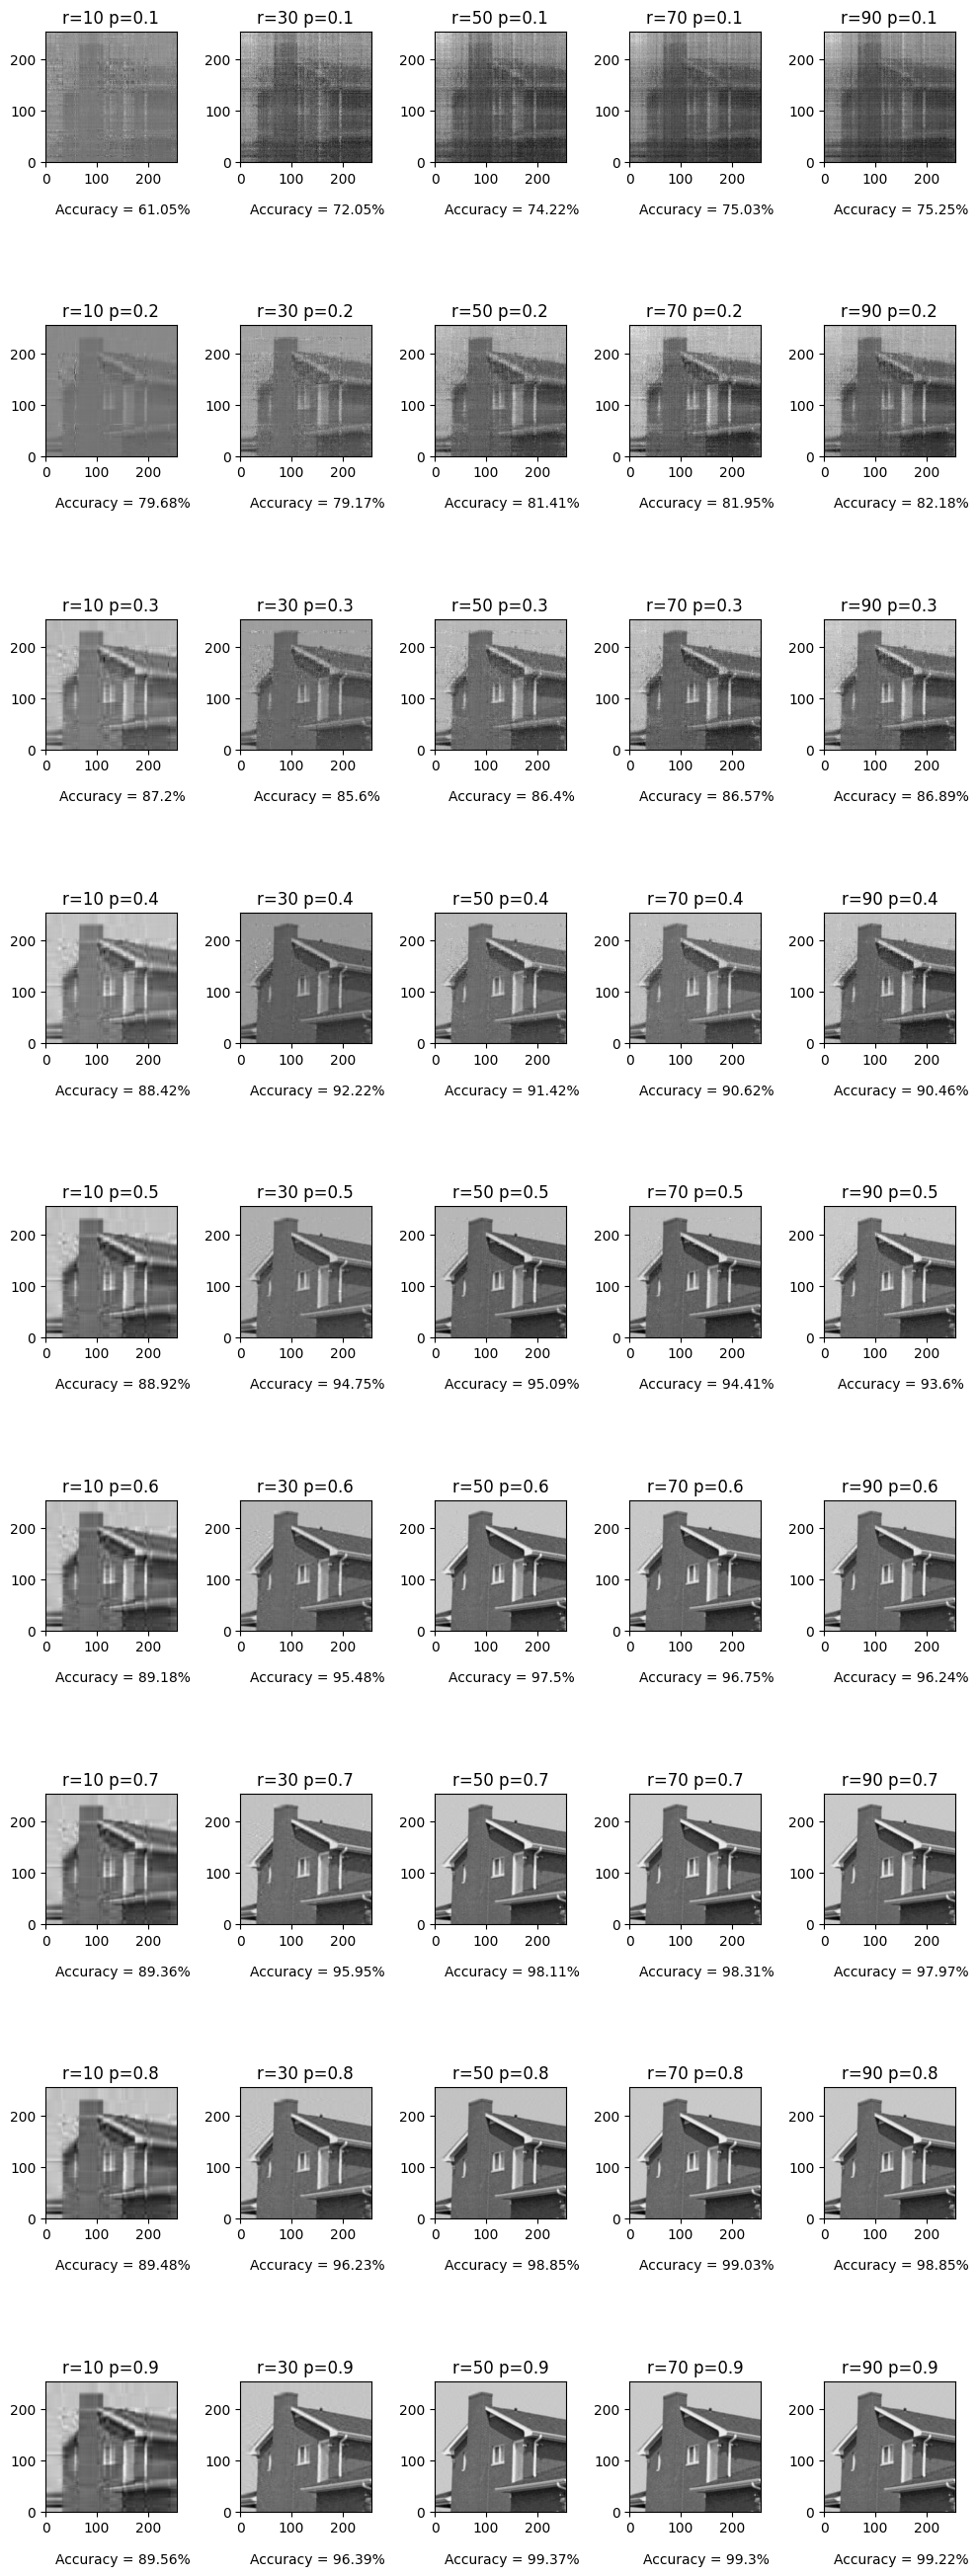

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy.linalg import norm

X = np.loadtxt('Test_Image.txt')
N = np.shape(X)
rho= 0.005
max_iters=500

r_values = np.arange(10, 100, 20)
p_values = np.round(np.arange(0.1, 1.0, 0.1),1)

fig, axs = plt.subplots(len(p_values), len(r_values), figsize=(10, 3 * len(p_values)))

for j in range(len(r_values)):
    for i, p in enumerate(p_values):
        t = 1 - p
        # Under-sampling the image
        np.random.seed(42)
        M = np.random.rand(N[0], N[1])
        M[M <= t] = 0
        M[M > 0] = 1
        D = M * X  # Under-sampled image D
        # Compute rank of the original matrix X
        r = r_values[j]
        # Compute the approximations and residuals of the under-sampled image using ASD algorithm
        X_cap, residuals = asd_algorithm(D, r, rho, max_iters)

        #Accuracy
        accuracy = np.round((100 - norm(X_cap - X)/norm(X) * 100),2)


        # Plot the under-sampled image
        axs[i, j].imshow(X_cap, cmap='gray', extent=[0, N[0] - 1, 0, N[1] - 1], aspect=1)
        axs[i, j].set_title(f'r={r_values[j]} p={p}')
        axs[i, j].text(150, -100, f"Accuracy = {accuracy}%", ha='center')



plt.tight_layout()
plt.show()

**Observations:**
- For a low under-sampling ratio of $p=0.1$, we observe substantial distortion and unrecognisable reconstructed images across a range of rank values. The accuracy values associated with these images underline the significant loss of information, particularly evident when $r$ is set to 10. However, as $p$ increases, a faint structure of the house becomes discernible. Notably, with $p=0.2$, the images exhibit slight improvement, yet the accuracy remains modest, averaging around 81\%.
- Intuitively, an increase in $p$ leads to a proportional improvement in image accuracy, as more pixels from the original image are retained. Our examination of a grid of outputs reveals that the lowest value of $p$, where the accuracy surpasses the 85\% mark is at 0.3. For $p=0.2$, the algorithm achieves an 80\% accuracy, indicating a commendable attempt at reconstructing the image and can also be considered of fair quality. From a simple eye-view this seems like an acceptable quality of the image. However, it is at $p=0.5$ that we first observe a remarkably clear output, particularly evident when $r$ is set to 50. This clarity is substantiated by an accuracy of 95.09\%, significantly outperforming other rank values.

## 6. Assessing robustness through data pertubation




### **6.1. Adding noise to the image:**
 - Corrupting the image artificially by adding a gaussian noise of mean 0 and standard deviation 1

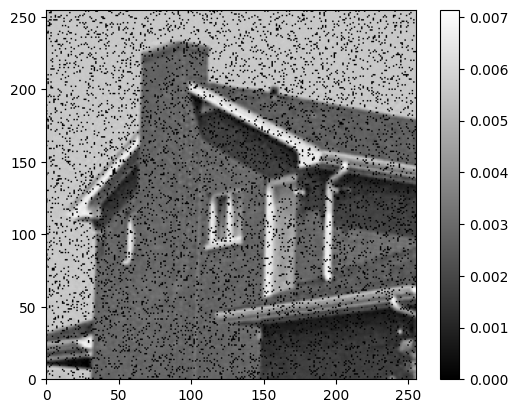

In [16]:
#import the required packages
from numpy.linalg import norm

# Load the original image and define its size by the array N
X = np.loadtxt('Test_Image.txt')
N = np.shape(X)

# Establish the random seed for reproducibility
np . random . seed (42)


# First , use np. random . normal (loc=mu , scale =sigma , size =(M,N)) to
# generate a list of normally distributed values with mean mu , standard
# deviation sigma and size MxN
R = np . random . normal ( loc =0.0 , scale =1.0 , size =( N [0] , N [1]) )

# Define the level of the perturbation by eta and impose the perturbation
# on X to give a perturbed image Xpert
eta = 0.01
pert = ( eta *( norm (X ,'fro') ) / norm (R ,'fro') ) * R
Xpert = X + pert

# Under - sample the data with an under - sampling ratio p
p = 0.5
M [M <= p ] = 0
M [M >0] = 1
Xpert = M * Xpert


plt.imshow(Xpert, cmap ='gray',extent =[0, N[0]-1,0 , N [1] -1] , aspect =1)
plt.colorbar()
plt.show()


### **6.2 Testing the ASD algorithm on the corrupted image**

- Running the algorithm on the perturbed image
- Displaying the recovered image


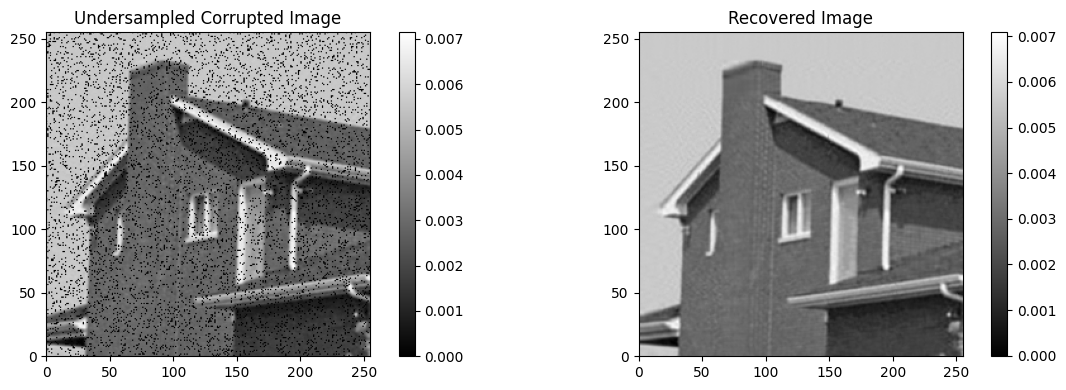

In [17]:
#import the required packages
from numpy.linalg import norm

# Load the original image and define its size by the array N
X = np.loadtxt('Test_Image.txt')
N = np.shape(X)

# Establish the random seed for reproducibility
np . random . seed (42)


# First , use np. random . normal (loc=mu , scale =sigma , size =(M,N)) to
# generate a list of normally distributed values with mean mu , standard
# deviation sigma and size MxN
R = np . random . normal ( loc =0.0 , scale =1.0 , size =( N [0] , N [1]) )

# Define the level of the perturbation by eta and impose the perturbation
# on X to give a perturbed image Xpert
eta = 0.01
pert = ( eta *( norm (X ,'fro') ) / norm (R ,'fro') ) * R
Xpert = X + pert

# Under - sample the data with an under - sampling ratio p
p = 0.5
M [M <= p ] = 0
M [M >0] = 1
Xpert = M * Xpert

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(Xpert, cmap ='gray',extent =[0, N[0]-1,0 , N [1] -1] , aspect =1)
plt.title('Undersampled Corrupted Image')
plt.colorbar()


#Setting up the stopping critera according to the question
rho = 0.005
max_iters = 500

#Computing the approximations and residuals of the undersampled image using ASD algorithm
X_cap, residuals = asd_algorithm(D, r, rho, max_iters)

#Subplot at 3rd position - Recovered image
plt.subplot(1,2,2)
plt.imshow(X_cap, cmap ='gray',extent =[0, N[0]-1,0 , N [1] -1] , aspect =1)
plt.title('Recovered Image')
plt.colorbar()

plt.tight_layout()
plt.show()

### **6.3. Varying the value of the undersampling ratio for the purpose of comparision**

- Displaying the recovered imaged by considering different values of the $p$ ranging from 0.1 to 0.9 increasing by 0.1 for each step
- Plotting the corresponding residuals

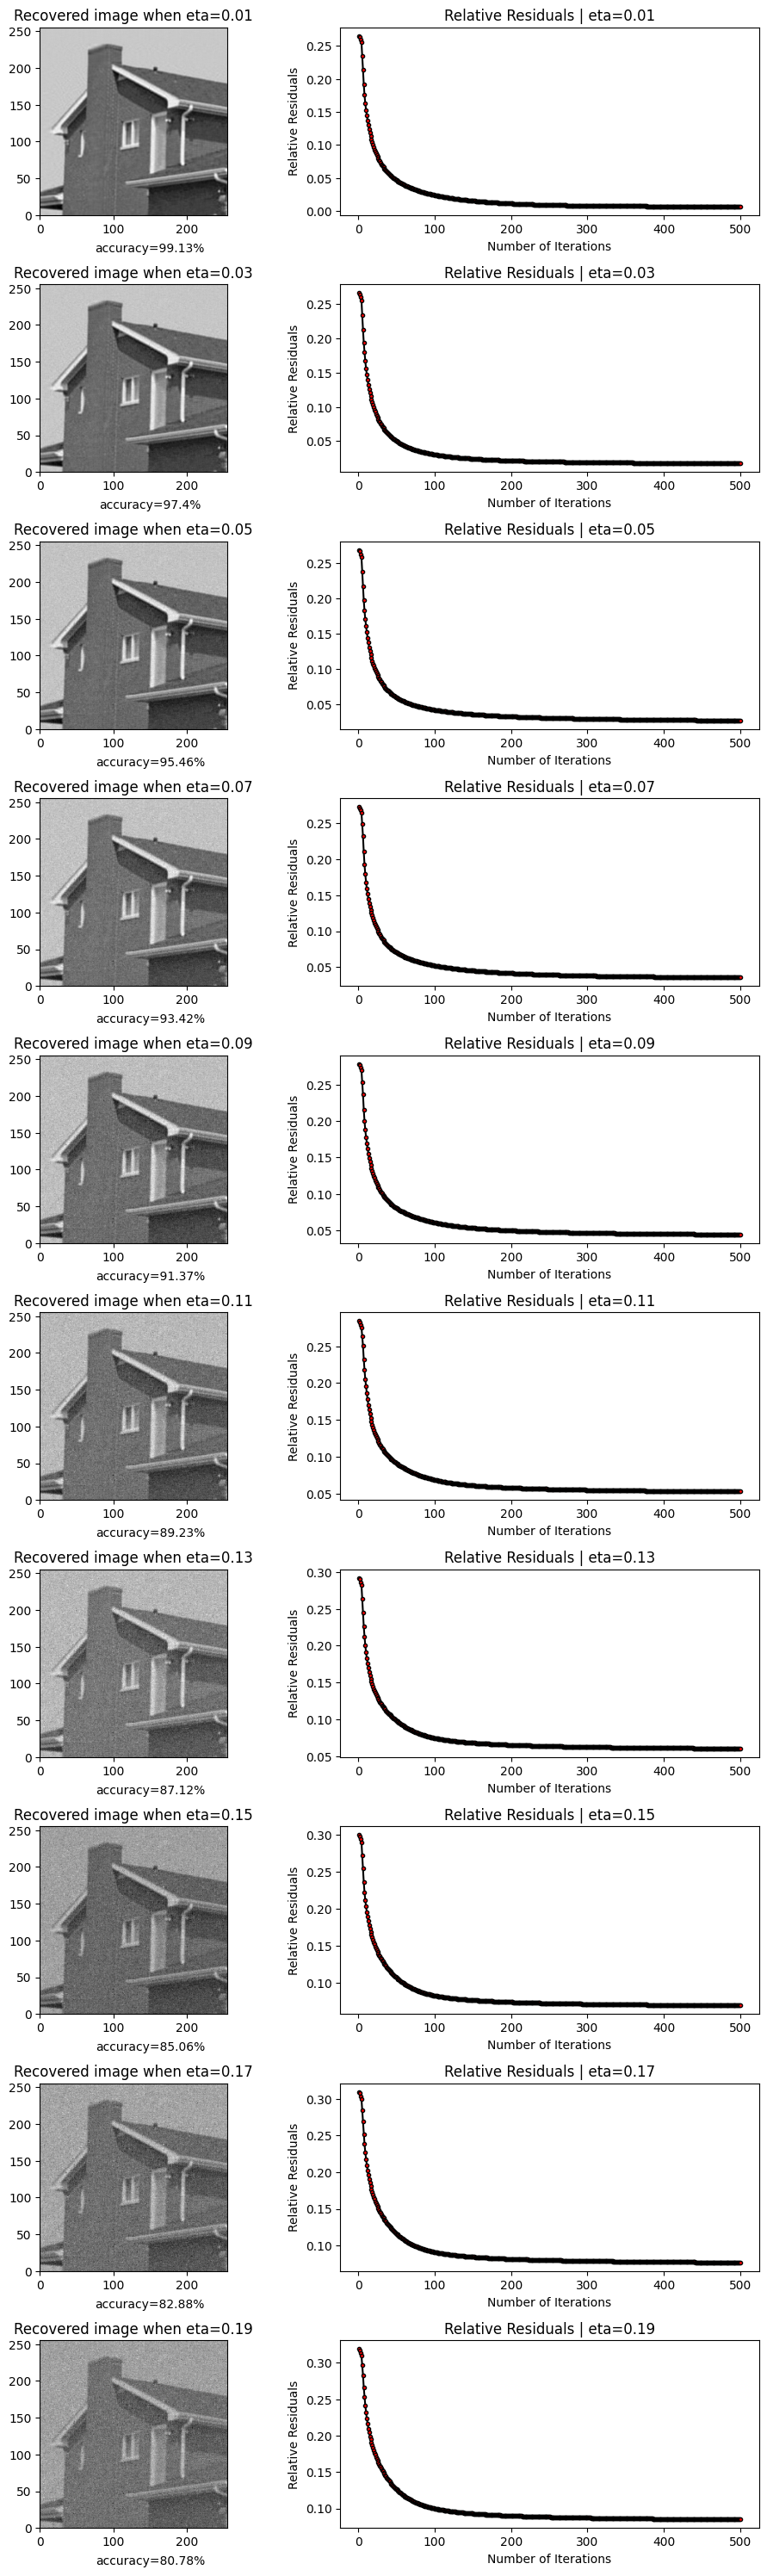

In [18]:
eta_values = np.round(np.arange(0.01,0.2,0.02),2)
rho = 0.005
max_iters = 500


fig, axs = plt.subplots(len(eta_values),2, figsize=(10,3 * len(eta_values)))


for i, eta in enumerate(eta_values):

    pert = ( eta *( norm (X ,'fro') ) / norm (R ,'fro') ) * R
    Xpert = X + pert

    # Under - sample the data with an under - sampling ratio p
    p = 0.5
    M [M <= p ] = 0
    M [M >0] = 1
    Xpert = M * Xpert

    # Compute the approximations and residuals of the under-sampled image using ASD algorithm
    X_cap, residuals = asd_algorithm(Xpert, r, rho, max_iters)

    #Accuracy
    accuracy = np.round((100 - norm(X_cap - X)/norm(X) * 100),2)

   # Plot the under-sampled image
    axs[i, 0].imshow(X_cap, cmap='gray', extent=[0, N[0] - 1, 0, N[1] - 1], aspect=1)
    axs[i, 0].set_title(f'Recovered image when eta={eta}')
    axs[i, 0].text(150,-50,f"accuracy={accuracy}%",ha ='center')

    # Plot the relative residuals
    axs[i, 1].plot(range(1, len(residuals) + 1), residuals, 'k', marker='o', markersize=3, markerfacecolor = 'red')
    axs[i, 1].set_title(f'Relative Residuals | eta={eta}')
    axs[i, 1].set_xlabel('Number of Iterations')
    axs[i, 1].set_ylabel('Relative Residuals')


plt.tight_layout()
plt.show()

### **6.4. Varying both $\eta$ and $r$ and making observations on recovered images:**

- Displaying the recovered imaged by considering different values of the $r = {10,30,50,70,90}$ and $\eta = {0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9}$

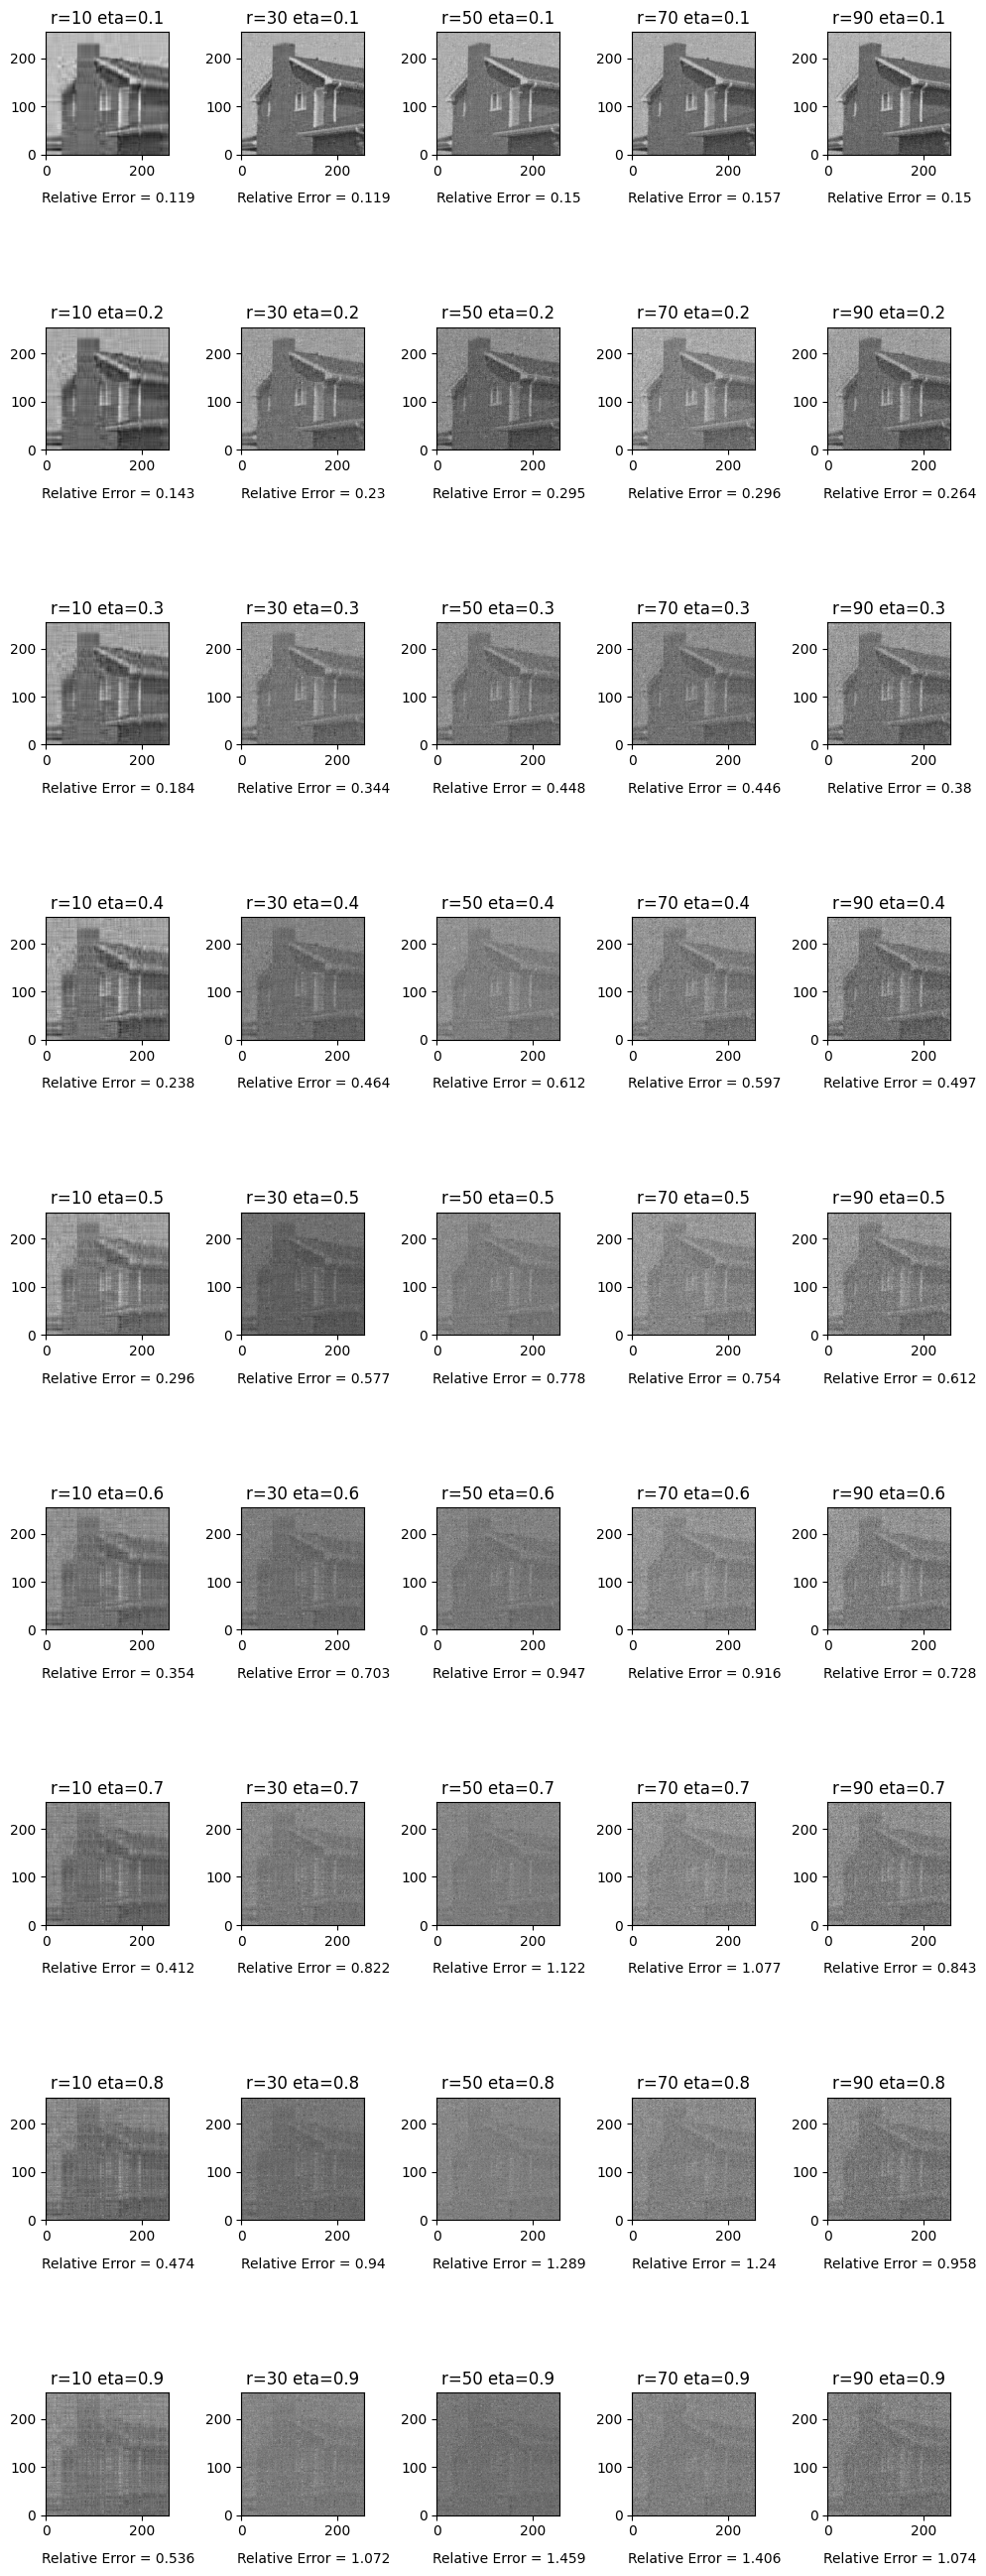

In [19]:
#Setting p=0.5
p=0.5
t = 1 - p
R = np.random.normal(loc =0.0 , scale=1.0 , size =(N[0],N[1]))

norm_frac = (norm(X,'fro')/ norm(R,'fro')) * R

r_values = np.arange(10, 100, 20)
eta_values = np.round(np.arange(0.1, 1.0, 0.1),1)

fig, axs = plt.subplots(len(eta_values), len(r_values), figsize=(10, 3 * len(eta_values)))

for j in range(len(r_values)):
    for i, eta in enumerate(eta_values):

        pert = eta * norm_frac
        Xpert = X + pert

        # Under-sampling the image
        np.random.seed(42)
        M = np.random.rand(N[0], N[1])
        M[M <= t] = 0
        M[M > 0] = 1
        D = M * Xpert  # Under-sampled image D
        # Compute rank of the original matrix X
        r = r_values[j]
        # Compute the approximations and residuals of the under-sampled image using ASD algorithm
        X_cap, R = asd_algorithm(D, r, rho, max_iters)

        #Relative error
        relative_error = np.round(norm(X_cap - X)/norm(X),3)

        # Plot the under-sampled image
        axs[i, j].imshow(X_cap, cmap='gray', extent=[0, N[0] - 1, 0, N[1] - 1], aspect=1)
        axs[i, j].set_title(f'r={r_values[j]} eta={eta}')
        axs[i, j].text(150, -100, f"Relative Error = {relative_error}", ha='center')


plt.tight_layout()
plt.show()

## 7 Testing on a different image/ modification of the same image




### **7.1 Making a checkerboard pattern, undersampling the image using that and testing the algorithm**

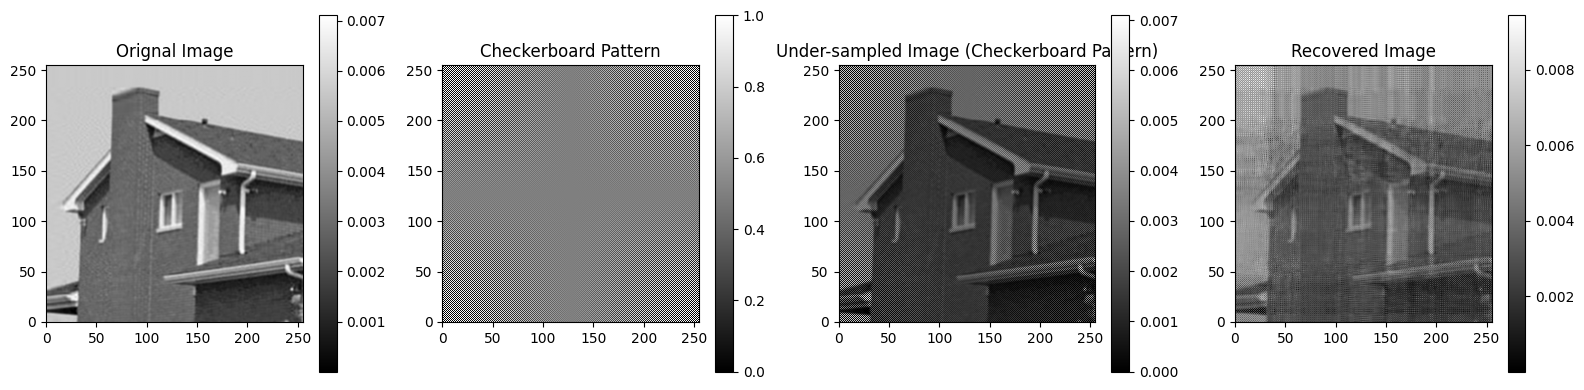

In [20]:
# Import the required packages
import numpy as np
import matplotlib.pyplot as plt

# Load the txt file and assign the data to the matrix X
X = np.loadtxt('Test_Image.txt')

# Obtain the size of the input matrix. The size will be given by N whose first element is the number of rows and the second is the number of columns.
N = np.shape(X)

# Plot the image encoded by the matrix X in grayscale
#Setting the size of the figure to maintain a constant and well-spaced images thoughout
plt.figure(figsize=(16,4))

#Creating a subplot of 1 row and 3 columns to display the images one under the other

#Sub-plot at 1st position - Original Image
plt.subplot(1,4,1)
plt.title('Orignal Image')
plt.imshow(X, cmap ='gray',extent =[0, N[0]-1,0 , N [1] -1] , aspect =1)
plt.colorbar()

# Create a checkerboard pattern

checkerboard = np.indices(N).sum(axis=0) % 2

# Show the checkerboard pattern
plt.subplot(1,4,2)
plt.imshow(checkerboard, cmap='gray', extent=[0, N[0] - 1, 0, N[1] - 1], aspect=1)
plt.colorbar()
plt.title('Checkerboard Pattern')


# Finally, the matrix D will be the mask M multiplied element-wise by the image X.
D = checkerboard * X

# Show the under-sampled image
plt.subplot(1,4,3)
plt.imshow(D, cmap='gray', extent=[0, N[0] - 1, 0, N[1] - 1], aspect=1)
plt.colorbar()
plt.title('Under-sampled Image (Checkerboard Pattern)')



#Setting up the stopping critera according to the question
rho = 0.005
max_iters = 500

#Computing the approximations and residuals of the undersampled image using ASD algorithm
X_cap, residuals = asd_algorithm(D, r, rho, max_iters)

#Subplot at 3rd position - Recovered image
plt.subplot(1,4,4)
plt.title('Recovered Image')
plt.imshow(X_cap, cmap ='gray',extent =[0, N[0]-1,0 , N [1] -1] , aspect =1)
plt.colorbar()

plt.tight_layout()
plt.show()



### **7.2 Testing on zoomed-in, rotated version of the image**

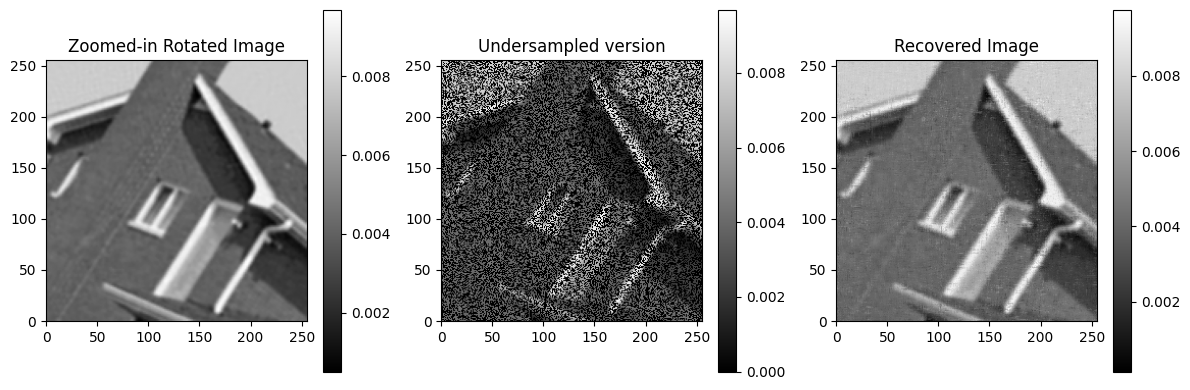

In [21]:
from PIL import Image

p = 0.5
t = 1-p

#Loading in the altered image
img= Image.open("Test_Image2.png").convert('L')
X = np.array(img) / (256*100)
N= np.shape(X)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title('Zoomed-in Rotated Image')
plt.imshow(X, cmap='gray', extent=[0,N[0]-1, 0, N[1]-1], aspect=1)
plt.colorbar()

M = np.random.rand(N[0],N[1])
M[M<=t] = 0
M[M>0] = 1
D = M*X

plt.subplot(1,3,2)
plt.title('Undersampled version')
plt.imshow(D, cmap='gray', extent=[0,N[0]-1, 0, N[1]-1], aspect=1)
plt.colorbar()

plt.tight_layout()


#Setting up the stopping critera according to the question
rho = 0.005
max_iters = 500

#Computing the approximations and residuals of the undersampled image using ASD algorithm
X_cap, residuals = asd_algorithm(D, r, rho, max_iters)

#Subplot at 3rd position - Recovered image
plt.subplot(1,3,3)
plt.title('Recovered Image')
plt.imshow(X_cap, cmap ='gray',extent =[0, N[0]-1,0 , N [1] -1] , aspect =1)
plt.colorbar()

plt.tight_layout()
plt.show()

